# Evaluating Performance of a Weather Model

In this assessment, we'll revisit the historical temperature dataset. We will perform the following tasks:
- First, load the dataset from the weatherinszeged table from Thinkful's database.
- As in the previous lesson, build a linear regression model where your target variable is the difference between the `apparenttemperature` and the `temperature`. As explanatory variables, use `humidity` and `windspeed`. Now, estimate your model using OLS. What are the R-squared and adjusted R-squared values? Do you think they are satisfactory? Why?
- Next, include the interaction of `humidity` and `windspeed` to the model above and estimate the model using OLS. Now, what is the R-squared of this model? Does this model improve upon the previous one?
- Add `visibility` as an additional explanatory variable to the first model and estimate it. Did R-squared increase? What about adjusted R-squared? Compare the differences put on the table by the interaction term and the `visibility` in terms of the improvement in the adjusted R-squared. Which one is more useful?
- Choose the best one from the three models above with respect to their AIC and BIC scores. Validate your choice by discussing your justification with your mentor.


First, we will import the relevant libraries and do the feature engineering steps. We will load the dataset from the weatherinszeged table.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn import linear_model
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sqlalchemy import create_engine, text

# Display preferences
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings(action="ignore")

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

with engine.begin() as conn:
    query = text("""SELECT * FROM weatherinszeged""")
    weather_df = pd.read_sql_query(query, conn)

# No need for an open connection, because you're only doing a single query
engine.dispose()

weather_df.head(10)

,date,summary,preciptype,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure,dailysummary
0,2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472,7.389,0.890,14.120,251.000,15.826,0.000,1015.130,Partly cloudy throughout the day.
1,2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.356,7.228,0.860,14.265,259.000,15.826,0.000,1015.630,Partly cloudy throughout the day.
2,2006-04-01 00:00:00+00:00,Mostly Cloudy,rain,9.378,9.378,0.890,3.928,204.000,14.957,0.000,1015.940,Partly cloudy throughout the day.
3,2006-04-01 01:00:00+00:00,Partly Cloudy,rain,8.289,5.944,0.830,14.104,269.000,15.826,0.000,1016.410,Partly cloudy throughout the day.
4,2006-04-01 02:00:00+00:00,Mostly Cloudy,rain,8.756,6.978,0.830,11.045,259.000,15.826,0.000,1016.510,Partly cloudy throughout the day.
5,2006-04-01 03:00:00+00:00,Partly Cloudy,rain,9.222,7.111,0.850,13.959,258.000,14.957,0.000,1016.660,Partly cloudy throughout the day.
6,2006-04-01 04:00:00+00:00,Partly Cloudy,rain,7.733,5.522,0.950,12.365,259.000,9.982,0.000,1016.720,Partly cloudy throughout the day.
7,2006-04-01 05:00:00+00:00,Partly Cloudy,rain,8.772,6.528,0.890,14.152,260.000,9.982,0.000,1016.840,Partly cloudy throughout the day.
8,2006-04-01 06:00:00+00:00,Partly Cloudy,rain,10.822,10.822,0.820,11.318,259.000,9.982,0.000,1017.370,Partly cloudy throughout the day.
9,2006-04-01 07:00:00+00:00,Partly Cloudy,rain,13.772,13.772,0.720,12.526,279.000,9.982,0.000,1017.220,Partly cloudy throughout the day.


We will also add the following helper function.

In [2]:
def plot_histogram(series,**kwargs):
    title = kwargs.get('title','Plot of series')
    xlabel = kwargs.get('xlabel','X-axis label')
    ylabel = kwargs.get('ylabel','count')
    plt.hist(series)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

We can see that there appears to be no null values and that several variables act as features for predicting temperature.

In [3]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   date                 96453 non-null  datetime64[ns, UTC]
 1   summary              96453 non-null  object             
 2   preciptype           96453 non-null  object             
 3   temperature          96453 non-null  float64            
 4   apparenttemperature  96453 non-null  float64            
 5   humidity             96453 non-null  float64            
 6   windspeed            96453 non-null  float64            
 7   windbearing          96453 non-null  float64            
 8   visibility           96453 non-null  float64            
 9   loudcover            96453 non-null  float64            
 10  pressure             96453 non-null  float64            
 11  dailysummary         96453 non-null  object             
dtypes: datetime64[ns, 

In [4]:
weather_df.describe()

,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure
count,96453.000,96453.000,96453.000,96453.000,96453.000,96453.000,96453.000,96453.000
mean,11.933,10.855,0.735,10.811,187.509,10.347,0.000,1003.236
std,9.552,10.697,0.195,6.914,107.383,4.192,0.000,116.970
min,-21.822,-27.717,0.000,0.000,0.000,0.000,0.000,0.000
25%,4.689,2.311,0.600,5.828,116.000,8.340,0.000,1011.900
50%,12.000,12.000,0.780,9.966,180.000,10.046,0.000,1016.450
75%,18.839,18.839,0.890,14.136,290.000,14.812,0.000,1021.090
max,39.906,39.344,1.000,63.853,359.000,16.100,0.000,1046.380


Before we build a linear regression model, we will confirm that the dataframe is approximately normally distributed. We will plot histograms for `temperature`,`apparenttemperature`,`humidity`, and `windspeed`.

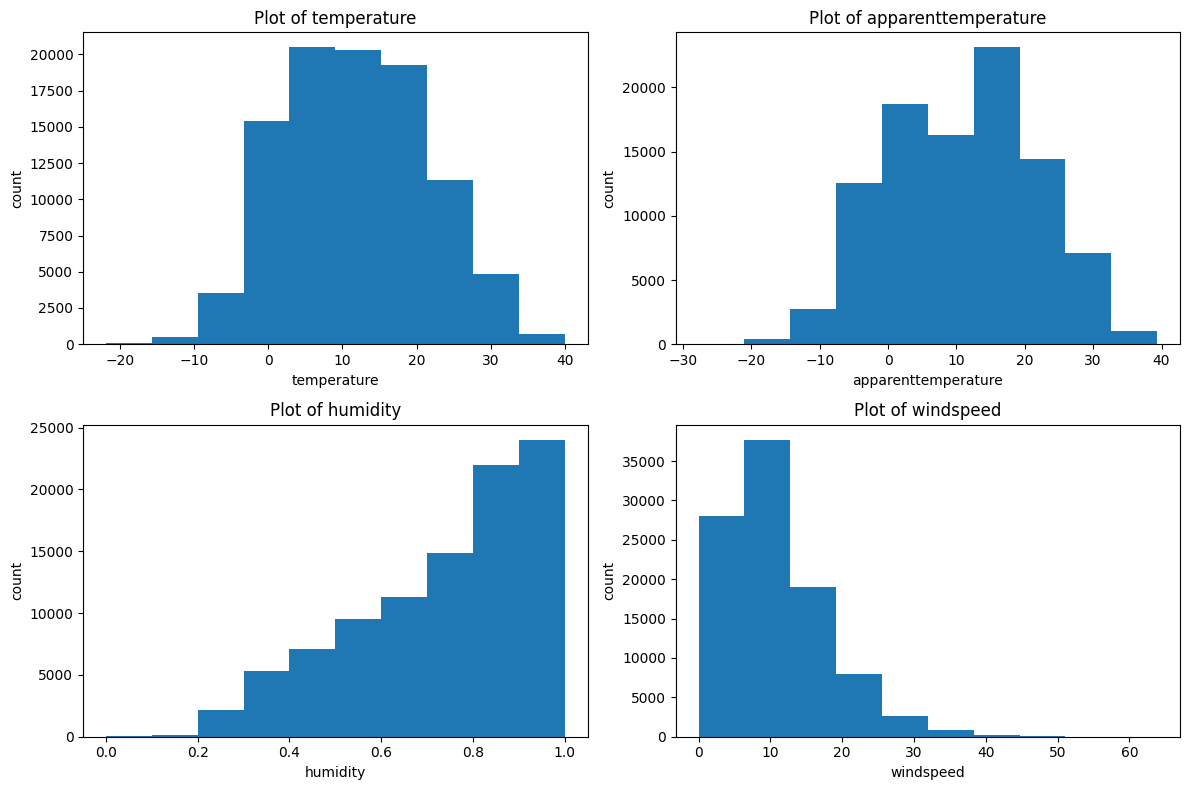

In [5]:
weather_features = ['temperature','apparenttemperature','humidity','windspeed']
weather_features_df = weather_df[weather_features]

def plot_histogram_with_subplots(series,i,**kwargs):
    title = kwargs.get('title','Plot of series')
    xlabel = kwargs.get('xlabel','X-axis label')
    ylabel = kwargs.get('ylabel','count')
    plt.subplot(2, 2, i)
    plt.hist(series)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

plt.figure(figsize=(12,8))
for idx, feature in enumerate(weather_features):
    plot_histogram_with_subplots(weather_df[feature],
                                 i = idx + 1,
                                 title="Plot of {}".format(feature),
                                 xlabel=feature)
plt.tight_layout()
plt.show()

We can see that both `humidity` and `windspeed` are highly skewed. For now we will ignore the skewness and estimate our model using OLS.

In [6]:
# Y is the target variable and is the difference between apparenttemperature and temperature.
Y = weather_df['apparenttemperature'] - weather_df['temperature']

# X is the feature set.
X = weather_df[['humidity','windspeed']]

X = sm.add_constant(X)
results = sm.OLS(Y, X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                 1.949e+04
Date:                Sat, 11 Nov 2023   Prob (F-statistic):               0.00
Time:                        18:44:57   Log-Likelihood:            -1.7046e+05
No. Observations:               96453   AIC:                         3.409e+05
Df Residuals:                   96450   BIC:                         3.409e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4381      0.021    115.948      0.000       2.397       2.479
humidity      -3.0292      0.024   -126.479      0.000      -3.076      -2.982
windspeed     -0.1193      0.001   -176.164      0.000      -0.121      -0.118
==============================================================================
Omnibus:                     3935.747   Durbin-Watson:                   0.267
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4613.311
Skew:                          -0.478   Prob(JB):                         0.00
Kurtosis:                       3.484   Cond. No.                         88.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- Here, the R-Squared and Adjusted R-Squared values are 0.288.
- We know that R-Squared and Adjusted R-Squared are better for higher values. The value of 0.288 means that 71.2% of the variation in the target variable is unexplained by the model. This suggests that our model is doing a poor job of explaining the variation in the target variable (however, in some cases, target variables are hard to explain and even the best models can explain a very low portion of the information in the target variable).


We will now include the interaction of `humidity` and `windspeed` to the model and plot the histogram of the interaction variable.

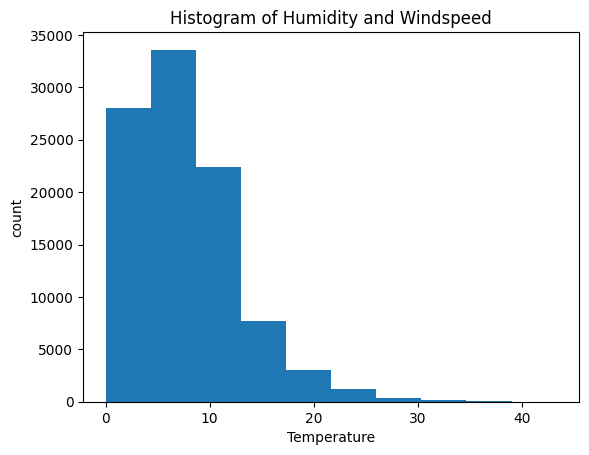

In [7]:
weather_df['humidity_windspeed_interaction'] = weather_df.humidity * weather_df.windspeed
plot_histogram(weather_df['humidity_windspeed_interaction'],
               xlabel="Temperature",
               title="Histogram of Humidity and Windspeed")

We can see that this new explanatory variable is also skewed. Now, we estimate the model through OLS.

In [8]:
# Y is the target variable and is the difference between apparenttemperature and temperature.
Y = weather_df['apparenttemperature'] - weather_df['temperature']

# X is the feature set including the interaction between humidity and windspeed.
X = weather_df[['humidity','windspeed','humidity_windspeed_interaction']]

X = sm.add_constant(X)
results = sm.OLS(Y, X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.341
Model:                            OLS   Adj. R-squared:                  0.341
Method:                 Least Squares   F-statistic:                 1.666e+04
Date:                Sat, 11 Nov 2023   Prob (F-statistic):               0.00
Time:                        18:44:58   Log-Likelihood:            -1.6669e+05
No. Observations:               96453   AIC:                         3.334e+05
Df Residuals:                   96449   BIC:                         3.334e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              0.0839      0.033      2.511      0.012       0.018       0.149
humidity                           0.1775      0.043      4.133      0.000       0.093       0.262
windspeed                          0.0905      0.002     36.797      0.000       0.086       0.095
humidity_windspeed_interaction    -0.2971      0.003    -88.470      0.000      -0.304      -0.291
==============================================================================
Omnibus:                     4849.937   Durbin-Watson:                   0.265
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9295.404
Skew:                          -0.378   Prob(JB):                         0.00
Kurtosis:                       4.320   Cond. No.                         193.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- This is an improvement from our previous model. The R_Squared and Adjusted R-Squared values are 0.341 which suggests that our new model explains 34.1% of the variance of the target variable. Now, only 65.9% of the variation in the target variable is unexplained by the model.

Next, we plot the histogram for `visibility`.

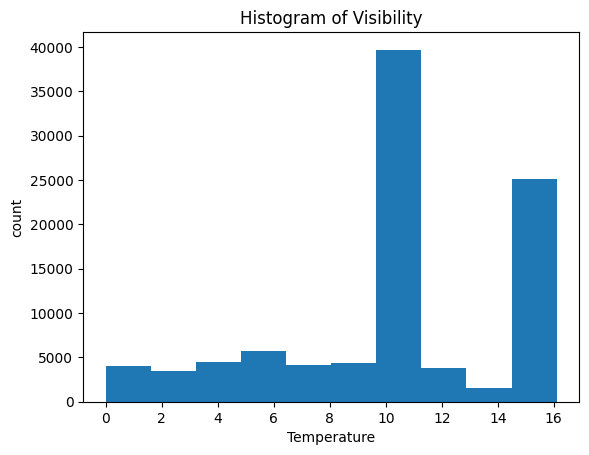

In [9]:
plot_histogram(weather_df['visibility'],
               xlabel="Temperature",
               title="Histogram of Visibility")

It is also skewed. We will now estimate our third model (including `visibility`) using OLS.

In [10]:
# Y is the target variable and is the difference between apparenttemperature and temperature.
Y = weather_df['apparenttemperature'] - weather_df['temperature']

# X is the feature set including the interaction between humidity and windspeed.
X = weather_df[['humidity','windspeed','visibility']]

X = sm.add_constant(X)
results = sm.OLS(Y, X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.303
Method:                 Least Squares   F-statistic:                 1.401e+04
Date:                Sat, 11 Nov 2023   Prob (F-statistic):               0.00
Time:                        18:44:58   Log-Likelihood:            -1.6938e+05
No. Observations:               96453   AIC:                         3.388e+05
Df Residuals:                   96449   BIC:                         3.388e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5756      0.028     56.605      0.000       1.521       1.630
humidity      -2.6066      0.025   -102.784      0.000      -2.656      -2.557
windspeed     -0.1199      0.001   -179.014      0.000      -0.121      -0.119
visibility     0.0540      0.001     46.614      0.000       0.052       0.056
==============================================================================
Omnibus:                     3833.895   Durbin-Watson:                   0.282
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4584.022
Skew:                          -0.459   Prob(JB):                         0.00
Kurtosis:                       3.545   Cond. No.                         131.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- This time R-Squared is 0.304 and Adjusted R-Squared is 0.303. This means that 69.6% of the variation in the target variable is unexplained by the model. This is better than the first model but worse than the second model. Therefore, the `interaction` term contributes more to the model. From this point of view, the `interaction` term can be regarded as more important than the `visibility` in explaining the information in the target variable.

- As was explained in the lesson, lower values are better for information criterions such as AIC and BIC. The first model's AIC and BIC values are 340900. The second model's are 333400 and the third model's are 338800. Among these, the model with the lowest AIC and BIC scores is the second model. So, the best of these three models is the second one.

To improve things further, we will apply the `log(1+x)` transformation of NumPy to `apparenttemperature` and `humidity`. We will then retest our model using OLS.

In [11]:
weather_df2 = weather_df.copy()
weather_df2['transformed_windspeed'] = np.log1p(weather_df2['windspeed'])
weather_df2['transformed_humidity'] = np.log1p(weather_df2['humidity'])
weather_df2['transformed_humidity_windspeed_interaction'] = np.log1p(weather_df2['humidity_windspeed_interaction'])
weather_df2['translated_apparenttemperature'] = np.log1p(weather_df2['apparenttemperature'] - min(weather_df2['apparenttemperature']))
weather_df2['translated_temperature'] = np.log1p(weather_df2['temperature'] - min(weather_df2['temperature']))


In [12]:
# Y is the target variable and is the difference between apparenttemperature and temperature.
Y = np.log1p(weather_df2['translated_apparenttemperature']) - weather_df2['translated_temperature']

# X is the feature set including the interaction between humidity and windspeed.
X = weather_df2[['transformed_humidity','windspeed','humidity_windspeed_interaction']]

X = sm.add_constant(X)
results = sm.OLS(Y, X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.344
Model:                            OLS   Adj. R-squared:                  0.344
Method:                 Least Squares   F-statistic:                 1.687e+04
Date:                Sat, 11 Nov 2023   Prob (F-statistic):               0.00
Time:                        18:44:59   Log-Likelihood:                 23949.
No. Observations:               96453   AIC:                        -4.789e+04
Df Residuals:                   96449   BIC:                        -4.785e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -2.7062      0.006   -482.567      0.000      -2.717      -2.695
transformed_humidity               1.2894      0.010    130.133      0.000       1.270       1.309
windspeed                          0.0074      0.000     21.447      0.000       0.007       0.008
humidity_windspeed_interaction    -0.0066      0.000    -13.920      0.000      -0.007      -0.006
==============================================================================
Omnibus:                    31555.627   Durbin-Watson:                   0.054
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           231788.385
Skew:                           1.381   Prob(JB):                         0.00
Kurtosis:                      10.074   Cond. No.                         292.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Our fourth model outperforms all three previous models.

# Evaluating Performance of the House Price Model

In this assessment, we'll work on our house prices model. We will perform the following tasks:

- Load the houseprices data from Thinkful's database.
- Run your house prices model again and assess the goodness of fit of your model using an F-test, R-squared, adjusted R-squared, AIC, and BIC.
- Do you think that your model is satisfactory? If so, why?
- In order to improve the goodness of fit of your model, try different model specifications by adding or removing some variables.
- For each model that you try, get the goodness-of-fit metrics and compare your models with each other. Which model is the best and why?


First, we will load the houseprices dataset.

In [13]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
with engine.begin() as conn:
    query = text("""SELECT * FROM houseprices""")
    house_price_df = pd.read_sql_query(query, conn)

# no need for an open connection, as we're only doing a single query
engine.dispose()

house_price_df.head(10)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.000,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000
5,6,50,RL,85.000,14115,Pave,None,IR1,Lvl,AllPub,...,0,None,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.000,10084,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,None,IR1,Lvl,AllPub,...,0,None,None,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.000,6120,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.000,7420,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,1,2008,WD,Normal,118000


As in a previous lesson, we will  clean the `bsmtqual` column.

In [14]:
bsmtqual_list = house_price_df['bsmtqual']

for i in range(0, len(bsmtqual_list)):
    if pd.isnull(bsmtqual_list[i]):
        bsmtqual_list[i] = 'TA'

bsmtqual_list.unique()

array(['Gd', 'TA', 'Ex', 'Fa'], dtype=object)

We will also confirm that the dataframe is approximately normally distributed.

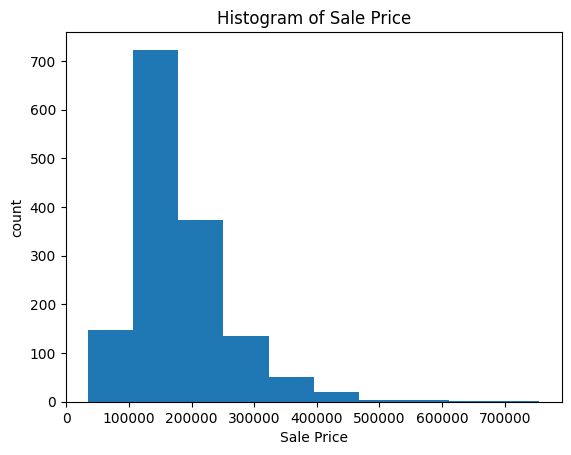

In [15]:
plot_histogram(house_price_df['saleprice'],
               xlabel="Sale Price",
               title="Histogram of Sale Price")

The dataframe is not exactly normally distributed. We previously found that the non-numerical features `mszoning`,`street`,`utilities`,`bsmtqual`, and `salecondition` are important to the sale price. Therefore, we will turn them into dummy variables.

In [16]:
dummy_column_names = []
def convert_to_dummy(df, names, dummy_column_names):
  for name in names:
    df = pd.concat([df,pd.get_dummies(df[name], prefix=name, drop_first=True)], axis=1)
  for name in names:
    dummy_column_names = dummy_column_names + list(pd.get_dummies(df[name], prefix=name, drop_first=True).columns)
  return df, dummy_column_names

house_price_df, dummy_column_names = convert_to_dummy(house_price_df, ['mszoning','street','utilities','bsmtqual','salecondition'], dummy_column_names)

Now let's estimate the model with the non-numerical features above and the numerical variables `overallqual`, `grlivarea`, `garagecars`, `garagearea`, and `totalbsmtsf`.

In [17]:
X = house_price_df[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf'] + dummy_column_names]
Y = house_price_df['saleprice']

X = sm.add_constant(X)
results = sm.OLS(Y, X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     300.9
Date:                Sat, 11 Nov 2023   Prob (F-statistic):               0.00
Time:                        18:45:05   Log-Likelihood:                -17374.
No. Observations:                1460   AIC:                         3.479e+04
Df Residuals:                    1440   BIC:                         3.489e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -3.277e+04   1.87e+04     -1.756      0.079   -6.94e+04    3841.995
overallqual            1.785e+04   1139.300     15.667      0.000    1.56e+04    2.01e+04
grlivarea                47.5101      2.331     20.384      0.000      42.938      52.082
garagecars              1.13e+04   2888.606      3.910      0.000    5629.241     1.7e+04
garagearea               10.6077      9.898      1.072      0.284      -8.808      30.024
totalbsmtsf              21.1576      2.812      7.523      0.000      15.641      26.674
mszoning_FV            2.452e+04    1.3e+04      1.887      0.059    -971.733       5e+04
mszoning_RH            1.683e+04   1.49e+04      1.130      0.259   -1.24e+04     4.6e+04
mszoning_RL            3.079e+04   1.21e+04      2.551      0.011    7112.717    5.45e+04
mszoning_RM            1.086e+04   1.22e+04      0.888      0.375   -1.31e+04    3.49e+04
street_Pave           -1093.6900   1.53e+04     -0.071      0.943   -3.12e+04     2.9e+04
utilities_NoSeWa      -1.788e+04   3.61e+04     -0.495      0.621   -8.87e+04    5.29e+04
bsmtqual_Fa           -6.357e+04   7835.106     -8.114      0.000   -7.89e+04   -4.82e+04
bsmtqual_Gd           -4.946e+04   4110.818    -12.031      0.000   -5.75e+04   -4.14e+04
bsmtqual_TA           -5.798e+04   4834.945    -11.992      0.000   -6.75e+04   -4.85e+04
salecondition_AdjLand  5015.4464   1.84e+04      0.272      0.786   -3.12e+04    4.12e+04
salecondition_Alloca   7849.9264   1.11e+04      0.705      0.481    -1.4e+04    2.97e+04
salecondition_Family  -7626.0005   8847.348     -0.862      0.389    -2.5e+04    9729.070
salecondition_Normal   9031.0803   3822.143      2.363      0.018    1533.515    1.65e+04
salecondition_Partial  2.016e+04   5246.434      3.843      0.000    9870.008    3.05e+04
==============================================================================
Omnibus:                      597.241   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            70631.579
Skew:                          -0.884   Prob(JB):                         0.00
Kurtosis:                      37.029   Cond. No.                     7.69e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.69e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

From these results we see that:
- R-squared and adjusted R-squared of the model are 0.799 and 0.796 respectively.
- F statistic and its associated p-value are 300.9 and 0.00 respectively.
- AIC and BIC of the model are 34790 and 34890 respectively.

According to the R-squared almost 80% of the variance in the target variable is explained by the model. Hence 20% of the variance in the target is not explained. In this sense, there is some room for improvement.

In order to increase the goodness of fit of our model:

- We first log transform the dependent variable. Recall from the histogram above that the `saleprice` variable is not normally distributed, so log transforming may help in this regard. To this end, we apply `log(1+x)` transformation of NumPy.
- Second, we create another variable by summing up the basement, first and the second floor areas.
- Third, we add the interaction of the total area and the overall quality of the house.
- Fourth, we drop the explanatory variable that aren't statistically significant.



In [18]:
house_price_df2 = house_price_df.copy()
unwanted_features = ['mszoning_FV','mszoning_RH',
                     'mszoning_RM','street_Pave',
                    'utilities_NoSeWa','salecondition_AdjLand',
                    'salecondition_Alloca','salecondition_Family']
dummy_column_names2 = [e for e in dummy_column_names if e not in unwanted_features]


In [19]:
house_price_df2['totalsf'] = house_price_df2['totalbsmtsf'] + house_price_df2['firstflrsf'] + house_price_df2['secondflrsf']
house_price_df2['int_over_sf'] = house_price_df2['totalsf'] * house_price_df2['overallqual']

# Y is the target variable
Y = np.log1p(house_price_df2['saleprice'])
# X is the feature set
X = house_price_df2[['overallqual', 'grlivarea', 'garagecars', 'totalbsmtsf', 'totalsf', 'int_over_sf'] + dummy_column_names2]

X = sm.add_constant(X)
results = sm.OLS(Y, X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     628.2
Date:                Sat, 11 Nov 2023   Prob (F-statistic):               0.00
Time:                        18:45:05   Log-Likelihood:                 601.74
No. Observations:                1460   AIC:                            -1177.
Df Residuals:                    1447   BIC:                            -1109.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    10.2870      0.056    183.748      0.000      10.177      10.397
overallqual               0.1744      0.008     20.925      0.000       0.158       0.191
grlivarea              6.094e-05   8.82e-05      0.691      0.490      -0.000       0.000
garagecars                0.0861      0.008     11.419      0.000       0.071       0.101
totalbsmtsf           -5.334e-05   9.09e-05     -0.586      0.558      -0.000       0.000
totalsf                   0.0004   9.22e-05      3.836      0.000       0.000       0.001
int_over_sf           -2.828e-05   2.78e-06    -10.155      0.000   -3.37e-05   -2.28e-05
mszoning_RL               0.1249      0.011     11.501      0.000       0.104       0.146
bsmtqual_Fa              -0.2571      0.035     -7.279      0.000      -0.326      -0.188
bsmtqual_Gd              -0.1207      0.019     -6.253      0.000      -0.159      -0.083
bsmtqual_TA              -0.1913      0.022     -8.567      0.000      -0.235      -0.148
salecondition_Normal      0.0949      0.015      6.469      0.000       0.066       0.124
salecondition_Partial     0.1426      0.022      6.571      0.000       0.100       0.185
==============================================================================
Omnibus:                      422.852   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2984.456
Skew:                          -1.159   Prob(JB):                         0.00
Kurtosis:                       9.610   Cond. No.                     2.68e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.68e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Now we see that:
- R-squared and adjusted R-squared of the model are 0.839 and 0.838 respectively. These are improvements upon the first model.
- F statistic and its associated p-value are 628.2 and 0.00 respectively. This also indicates that the second model is better than the first one.
- AIC and BIC of the model are -1177 and -1109 respectively. These values are lower than the ones of the first model. Hence, the second model is better than the first model.

These metrics suggest that the second model performs significantly better than the first model.